## This notebook answers the Question 2: Should the Department of Housing Preservation and Development of New York City focus on any particular set of boroughs, ZIP codes, or street (where the complaints are severe) for the specific type of complaints you identified in response to Question 1?

   ## <font color=red > Prepare Libraries 
  

In [1]:
!pip install --upgrade pip


Requirement already up-to-date: pip in /Applications/anaconda/lib/python3.5/site-packages (19.1.1)


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
##%%capture                
##! pip install seaborn    
import seaborn as sns
%matplotlib inline    
!pip install Folium
import folium

   ## <font color=red > Read data


In [5]:
df = pd.read_csv('./data/NYCdata.csv')

## Method 1: Using a brute-force approach

In [6]:

# Selecting rows with 'HEAT/HOT WATER' 
df_complaint = df.loc[df['complaint_type']=='HEAT/HOT WATER'].dropna()

df_complaint_incident_zip= np.zeros(shape=(len(df_complaint['incident_zip'].unique()),2))
   
for i, zip_code in enumerate(df_complaint['incident_zip'].unique()):
#    df_complaint_address[i,0]=i
    df_complaint_incident_zip[i,0]=zip_code
    df_complaint_incident_zip[i,1]=sum(df_complaint['incident_zip']==zip_code)

# argument for area having maximum complaints
arg_max = np.argmax(df_complaint_incident_zip[:,1])
# zip address for maximum complaint location
zip_max_complaints = df_complaint_incident_zip[arg_max,0]
# maximum number of complaint in the above zip
maximum_complaints = np.max(df_complaint_incident_zip[:,1])

print('Zip area:', int(zip_max_complaints), 'has maxmimum no of complaints:', int(maximum_complaints))
# just to check out which borough had maximum complaints
print(df_complaint.set_index('incident_zip').loc[zip_max_complaints]['city'])



KeyboardInterrupt: 

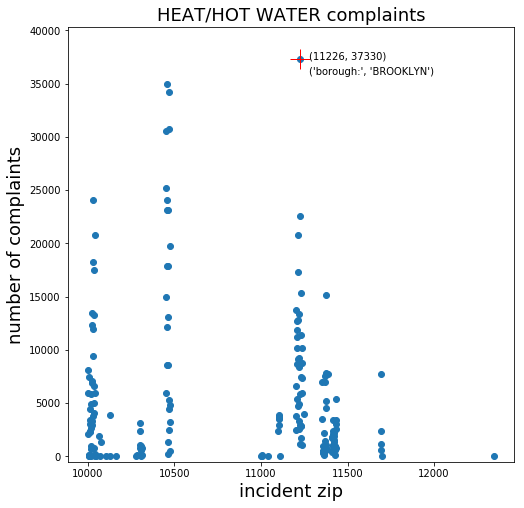

In [8]:
#plot
plt.figure(figsize=(8,8))
plt.scatter(df_complaint_incident_zip[:,0],df_complaint_incident_zip[:,1])
plt.plot(zip_max_complaints, maximum_complaints, 'r+', markersize=20)
plt.text(zip_max_complaints+50, maximum_complaints,(int(zip_max_complaints),int(maximum_complaints)))
plt.text(zip_max_complaints+50, maximum_complaints-1500, ('borough:', 'BROOKLYN'))
plt.xlabel('incident zip', fontsize = 18)
plt.ylabel('number of complaints', fontsize= 18)
plt.title('HEAT/HOT WATER complaints', fontsize = 18)
plt.ylim((-500, int(maximum_complaints)+3000))
plt.rcParams.update({'font.size': 12})


### <font color=blue>The above plot shows the maximum complaints and its zip code. With zip code we can also specify the borough. We can also infer that there is clustering with zip codes, so it suggest one can use machine learning models like clustering to get the broughs which are severly affected by HEAT/HOT Water complaints. However, this method gives only maximum complaint borough not all severly affrected boroughs. Additonaly, it uses loop in its script, which makes the simulation very slow and memory consuming. 

## <font color=red> Solution of problem 2: Zip area: 11226 has maxmimum no of complaints: 37369 with HEAT/HOT WATER problem.
    
    
    

## Method 2

### <font color=blue> Here we use some clever data wrangling techniques, which makes the analysis process very efficient.

In [9]:
#df_complaint.columns.values
#df = df_complaint.loc[df_complaint['incident_zip'].unique(),['borough', 'city', 'incident_zip', 'latitude', 'longitude']]
#df.shape
df_complaint = df.loc[df['complaint_type']=='HEAT/HOT WATER'].dropna()

#df_complaint.index = range(len(df_complaint.index))
##df_complaint = df_complaint.reindex(new_index)
df = df_complaint.loc[:,['borough', 'city', 'incident_zip']]
##df = df.set_index('incident_zip')
##df = df['incident_zip'].drop_duplicates(keep='first')
df = df.loc[~df['incident_zip'].duplicated()]
##df.groupby(['incident_zip', 'borough']).sum()
##df.index.drop_duplicates(keep='first')
df = df.sort_values(by = ['incident_zip'], ascending=True)
df.index = range(len(df.index))


# for no of complaints
df_number_incidents = df_complaint[['incident_zip', 'unique_key']].groupby(['incident_zip']).count()['unique_key']
df_number_incidents.index = range(len(df_number_incidents.index))



df_geo = df_complaint[['incident_zip', 'latitude', 'longitude']]
df_geo = df_geo.groupby(['incident_zip']).mean()
df_geo = df_geo.reset_index()
#df_geoplot = df_geoplot.groupby(['incident_zip']).size()
df_geo.loc[:, 'borough'] = df.loc[:,'borough']
df_geo.loc[:, 'city'] = df.loc[:, 'city']
df_geo['no_of_complaints'] = df_number_incidents
df_geo.head(3)


,incident_zip,latitude,longitude,borough,city,no_of_complaints
0,10001.0,40.748795,-73.995922,MANHATTAN,NEW YORK,2080
1,10002.0,40.717092,-73.989492,MANHATTAN,NEW YORK,8120
2,10003.0,40.730365,-73.987855,MANHATTAN,NEW YORK,5921


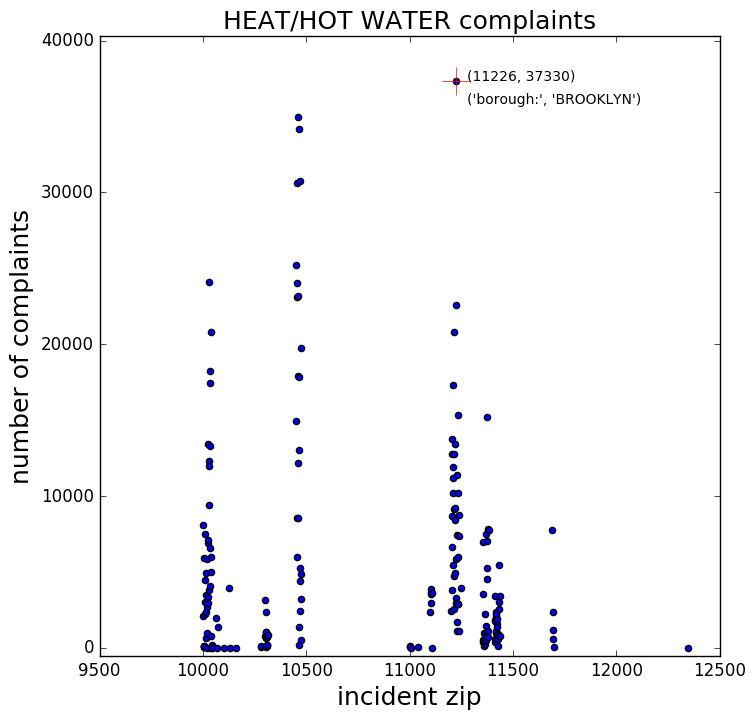

In [10]:
# argument for area having maximum complaints
arg_max = np.argmax(df_geo.loc[:,'no_of_complaints'])
# maximum number of complaint in the above zip
maximum_complaints = np.max(df_geo.loc[:,'no_of_complaints'])
# zip address for maximum complaint location
zip_max_complaints = df_geo.loc[arg_max,'incident_zip']

#plot
plt.figure(figsize=(8,8))
plt.scatter(df_geo.loc[:,'incident_zip'],df_geo.loc[:,'no_of_complaints'])
plt.plot(zip_max_complaints, maximum_complaints, 'r+', markersize=20)
plt.text(zip_max_complaints+50, maximum_complaints,(int(zip_max_complaints),int(maximum_complaints)))
plt.text(zip_max_complaints+50, maximum_complaints-1500, ('borough:', 'BROOKLYN'))
plt.xlabel('incident zip', fontsize = 18)
plt.ylabel('number of complaints', fontsize= 18)
plt.title('HEAT/HOT WATER complaints', fontsize = 18)
plt.ylim((-500, int(maximum_complaints)+3000))
plt.rcParams.update({'font.size': 12})


### Now I will show the boroughs that are severly affected

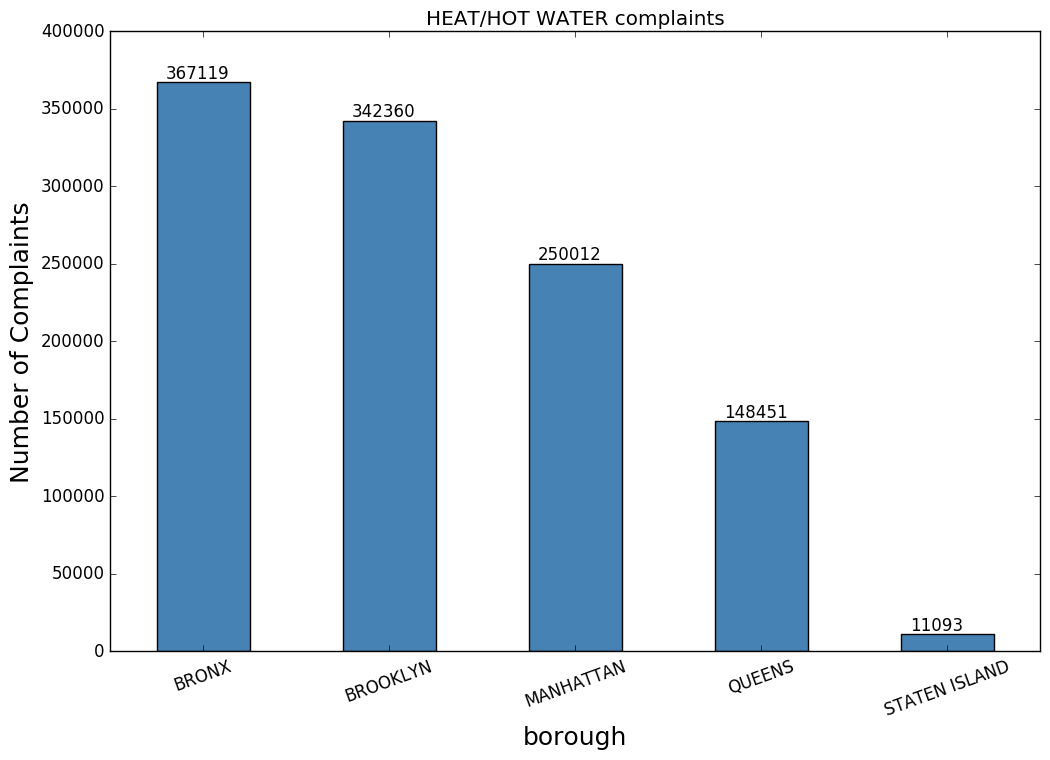

In [11]:
# use borough to get no of complaints statistics
#fig, ax = plt.subplots(figsize=(19,7))
df_borough = df_geo[['borough', 'no_of_complaints']].groupby(['borough']).sum()
df_borough = df_borough.reset_index()
df_borough.loc[:,'val'] = df_borough.loc[:,'no_of_complaints']
df_borough.loc[:,'x'] = range(len(df_borough.no_of_complaints))

ax = df_borough.set_index('borough')['no_of_complaints'].plot(kind='bar', figsize=(12, 8), color='steelblue')
plt.xlabel('borough', size = 18)
plt.ylabel('Number of Complaints', size = 18)
plt.title('HEAT/HOT WATER complaints')

# annotate value labels to each country
def label_point(x, no_of_complaints, val, ax):
    a = pd.concat({'x': x, 'no_of_complaints': no_of_complaints, 'val':val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['no_of_complaints'], str(int(point['val'])))   

        
        
label_point(df_borough.x-0.20, df_borough.no_of_complaints+2700, df_borough.val, ax)
plt.rcParams.update({'font.size': 12})
plt.xticks(rotation = 20)
plt.show()


In [12]:
df_borough = df_geo[['borough', 'no_of_complaints']].groupby(['borough']).sum()
df_borough = df_borough.reset_index()
df_borough.loc[:,'val'] = df_borough.loc[:,'no_of_complaints']

df_borough.val

0    367119
1    342360
2    250012
3    148451
4     11093
Name: val, dtype: int64

### Next we try to use geoplotting to help visualize the street view. I have further used markercluster. It makes the congusted looking  incident zip popup labels to form clusters, which can be zoomed in to look for more details.

In [13]:

# let's start again with a clean copy of the map of NYC centered around BROOKLYN
NYC_map = folium.Map(location=[df_geo['latitude'].mean(),df_geo['longitude'].mean()], zoom_start=12)

NYC_map


In [14]:
latitudes = list(df_geo.latitude)
longitudes = list(df_geo.longitude)
labels = list(map(str, df_geo.incident_zip.astype(int)))


In [15]:
from folium.plugins import MarkerCluster

# instantiate a mark cluster object for the incidents in the dataframe
complaints = MarkerCluster().add_to(NYC_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, label in zip(latitudes, longitudes, labels):
    folium.Marker(
        location=[lat, lng],
        icon=None,
        popup=label,
    ).add_to(complaints)

# display map
NYC_map

# <font color=red> Concluding Remark:
- The above analysis shows the severly affected boroughs with the HEATING complaints. In addition we show the number of complaints in histogram visulization. 
- Furthermore, to make the use of zip code I have used street view map and clusters to represent the problem affected area more concisely. This map is interactive and hence gives managers to spot immidiatley the top complaints areas.  